# The main objective of this notebook is to build a Recurrent Neural Network (RNN) model using the Twitter US Airline Sentiment dataset to perform sentiment classification on tweets as positive, neutral, or negative.

* Dataset Link : https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment?utm_source=chatgpt.com

For this dataset CPU of google colab is used but IDE like VS Code, pycharm etc can be used

In [4]:
# mounting drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
import os
os.listdir("/content/drive/My Drive")

['DriveSharer',
 'Kolop',
 'GDToT',
 'WhatsApp Image 2024-12-20 at 22.40.37_fcdc2f8a.jpg',
 'Colab Notebooks',
 'WhatsApp Image 2025-02-08 at 20.49.09_02e7cb53.jpg',
 'Copy of VC_RedistInstaller.exe',
 'To-do list.gsheet',
 'Google sheets',
 'Untitled spreadsheet.gsheet',
 'changed data type(numeric) (2).xlsx',
 'changed data type(numeric) (1).xlsx',
 'changed data type(numeric).xlsx',
 'changed data type(numeric).gsheet',
 'df_78_data.xlsx',
 'pratice sheet.gsheet',
 'Ask Gemini about the role of pyhton in plant bree... (5).gdoc',
 'Ask Gemini about the role of pyhton in plant bree... (4).gdoc',
 'Ask Gemini about the role of pyhton in plant bree... (3).gdoc',
 'Ask Gemini about the role of pyhton in plant bree... (2).gdoc',
 'Ask Gemini about the role of pyhton in plant bree... (1).gdoc',
 'Ask Gemini about the role of pyhton in plant bree....gdoc',
 'Emails to different stakeholders.gdoc',
 'mmem.jpg',
 'Tableau',
 'Learner-facing C3 Automatidata dataset for Tableau project (2).gshe

In [6]:
dataset_dir = ("/content/drive/My Drive/Dl Models/RNN")
os.listdir(dataset_dir)

['Tweets.csv', 'RNN+NLP.ipynb']

From here whole procedure for model will begin if you are using any IDE


In [ ]:
!pip install contractions --quiet
!pip install emoji --quiet


In [7]:
# Libraries required
#  --------------------- Core Libraries ---------------------
import os
import re
import emoji
from google.colab import drive
import numpy as np
import contractions
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
#  --------------------- Data Preprocessing ---------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

#  --------------------- NLP Text Preparation ---------------------
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#  --------------------- Class Imbalance Handling ---------------------
from sklearn.utils.class_weight import compute_class_weight

#  --------------------- Deep Learning Model (RNN + LSTM) ---------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#  --------------------- Model Evaluation ---------------------
from sklearn.metrics import confusion_matrix, classification_report


## Loading and Cleaning

In [8]:
df = pd.read_csv("/content/drive/My Drive/Dl Models/RNN/Tweets.csv")
df.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

Getting all missing values


In [10]:
print(f"Missing values & Null values:", df.isnull().sum())

Missing values & Null values: tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


In dataset some columns have lots of missing values so best practice is to drop them as they have no valueable information


In [11]:
# Dropping columns those are irrelenvent and have more than 50% missing values
df = df.drop(columns=['negativereason', 'negativereason_confidence', 'airline_sentiment_gold',
                      'negativereason_gold', 'tweet_coord', 'tweet_location',
                     'user_timezone', 'name'])

In [12]:
# Checking for rows if they are missing text and sentiment
missing_rows = df[df['text'].isna() | df['airline_sentiment'].isna()]

print(f"Total rows with missing text or sentiment: {missing_rows.shape[0]}")

Total rows with missing text or sentiment: 0


In [13]:
# Confirming cleaning of columns and rows
print("Remaining missing values:")
print(df.isnull().sum())

Remaining missing values:
tweet_id                        0
airline_sentiment               0
airline_sentiment_confidence    0
airline                         0
retweet_count                   0
text                            0
tweet_created                   0
dtype: int64


Right now, there is no missing value in whole dataset

### Removing Duplicates

In [14]:
# Checking duplicate
total_duplicates = df.duplicated().sum()
print(f"Total duplicate rows in the dataset: {total_duplicates}")

Total duplicate rows in the dataset: 80


There are duplicated rows. They must be dropped.

In [15]:
# Dropping duplicate
df = df.drop_duplicates()


In [16]:
# Checking duplicates
after_cleaning = df.duplicated().sum()
print(f"Duplicated after dropping them: {after_cleaning}")

Duplicated after dropping them: 0


## Visualization of Distribution


In [17]:
# Sentiment Distribution
fig1 = px.histogram(df, x='airline_sentiment',
                    title='Distribution of Tweet Sentiment',
                    color='airline_sentiment',
                    text_auto=True)
fig1.show()

This tells us about neutral, positive and negative distribution of tweets

In [18]:
fig2 = px.histogram(df, x='airline', color='airline_sentiment',
                    title='Sentiment per Airline',
                    barmode='group', text_auto=True)
fig2.show();

This shows distribution of sentiment per airline.

In [19]:
# Tweet text length distribution
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
fig3  = px.histogram(df, x='text_length',
                     nbins=50,
                     title='Distribution of Tweet Length')
fig3.show()

This checks how long tweets are.

Above three plotted visualziation helps in:
* 1st graph for number of all tweets
* 2nd graph useful for analysis of class balancing
* 3rd graph for deciding max sequence length for RNN tokenization

### Cleaning Text for NLP

As this dataset is from tweeter. There is poosibility of presence of emojis in it. So detecting and solving this issue is also important

In [20]:
# Checking if emoji is present


# Function to check emoji
def has_emoji(text):
  return any(char in emoji.EMOJI_DATA for char in text)

# Applying to dataset
df['contains_emoji'] = df['text'].apply(has_emoji)

# Count how many tweets have emojis
num_emoji_tweet = df['contains_emoji'].sum()
print(f'Number of tweets containing emojis: {num_emoji_tweet}')

# View first few emojis
print(df[df['contains_emoji']].head(10)[['text']])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 23.9 MB/s eta 0:00:00
Number of tweets containing emojis: 492
                                                  text
18                     I ❤️ flying @VirginAmerica. ☺️👍
24   @VirginAmerica you guys messed up my seating.....
30   @VirginAmerica hi! I just bked a cool birthday...
36   @VirginAmerica Moodlighting is the only way to...
42   @VirginAmerica plz help me win my bid upgrade ...
57   @VirginAmerica @ladygaga @carrieunderwood  I'm...
62   @VirginAmerica @ladygaga @carrieunderwood all ...
105  @VirginAmerica - amazing customer  service, ag...
113                @VirginAmerica Have a great week 🌞✈
142  @VirginAmerica Can you find us a flt out of LA...


Here found emojis in dataset. They must be solved. Emojis contain emotions if they are converted into words, they can be helpful for model training

In [21]:
# Converting emojis into texts
def emoji_to_text(text):
  return emoji.demojize(text, delimiters=(" ", " "))
df['clean_text'] = df['text'].apply(emoji_to_text)

# Checking results
print(df[df['contains_emoji']].head(10)[['text', 'clean_text']])

                                                  text  \
18                     I ❤️ flying @VirginAmerica. ☺️👍   
24   @VirginAmerica you guys messed up my seating.....   
30   @VirginAmerica hi! I just bked a cool birthday...   
36   @VirginAmerica Moodlighting is the only way to...   
42   @VirginAmerica plz help me win my bid upgrade ...   
57   @VirginAmerica @ladygaga @carrieunderwood  I'm...   
62   @VirginAmerica @ladygaga @carrieunderwood all ...   
105  @VirginAmerica - amazing customer  service, ag...   
113                @VirginAmerica Have a great week 🌞✈   
142  @VirginAmerica Can you find us a flt out of LA...   

                                            clean_text  
18   I  red_heart  flying @VirginAmerica.  smiling_...  
24   @VirginAmerica you guys messed up my seating.....  
30   @VirginAmerica hi! I just bked a cool birthday...  
36   @VirginAmerica Moodlighting is the only way to...  
42   @VirginAmerica plz help me win my bid upgrade ...  
57   @VirginAmerica

This will remove:
* URLs

* @mentions

* #hashtags

* punctuation / special chars

* extra spaces, emojis

* lowercase everything

This wiil convert raw tweets into clean, token-ready text

In [22]:
# Cleaning Text

def clean_tweet(text):
  text = re.sub(r"http\S+", "",text)
  text = re.sub(r"@\w+", "", text)
  text = re.sub(r"#\w+", "", text)
  text = re.sub(r"[^A-Za-z\s:]", "", text)
  text = text.lower().strip()
  return text

df['clean_text'] = df['clean_text'].apply(clean_tweet)

In [23]:
print("Seeing dataset after removing errors in text column:")
print(df['clean_text'].head(10))

Seeing dataset after removing errors in text column:
0                                           what  said
1    plus youve added commercials to the experience...
2    i didnt today must mean i need to take another...
3    its really aggressive to blast obnoxious enter...
4              and its a really big bad thing about it
5    seriously would pay  a flight for seats that d...
6    yes nearly every time i fly vx this ear worm w...
7    really missed a prime opportunity for men with...
8                          well i didntbut now i do :d
9    it was amazing and arrived an hour early youre...
Name: clean_text, dtype: object


After cleaning texts like "can't" into "can not" are helpful in model training

In [24]:
# Text contractions

def expand_contractions(text):
  return contractions.fix(text)

df['text'] = df['text'].apply(expand_contractions)
print("Contractions expanded in text")

Contractions expanded in text


### As airline_sentiment column has positive, negtive and neutral text. As RNN can't understand texts so label encoding of those meaning in form of 0,1 and 2 for model training

In [25]:
# Text Label Encoding

le = LabelEncoder()
df['sentiment_label'] = le.fit_transform(df['airline_sentiment'])
y = df['sentiment_label']

print("Classes:", le.classes_)
print(df[['airline_sentiment', 'sentiment_label']].head(10))

Classes: ['negative' 'neutral' 'positive']
  airline_sentiment  sentiment_label
0           neutral                1
1          positive                2
2           neutral                1
3          negative                0
4          negative                0
5          negative                0
6          positive                2
7           neutral                1
8          positive                2
9          positive                2


Dataset Balancing is necessary for getting better results from our model. So dataset balancing is important


In [26]:
# Balancing dataset

neg = df[df['airline_sentiment'] == 'negative']
neu = df[df['airline_sentiment'] == 'neutral']
pos = df[df['airline_sentiment'] == 'positive']

neu_up = resample(neu, replace=True, n_samples=len(neg), random_state=42)
pos_up = resample(pos, replace=True, n_samples=len(neg), random_state=42)

df = pd.concat([neg, neu_up, pos_up])
print(df['airline_sentiment'].value_counts())

airline_sentiment
negative    9116
neutral     9116
positive    9116
Name: count, dtype: int64


In procedure of tokenization which includes conversion of texts into numbers and padding which make all sequence of same length. There are two parameters those must be adressed:
* MAX_WORDS
* MAX_LEN


So, values of both can be determined by given code

In [27]:
# Determining max words

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
total_vocab = len(tokenizer.word_index)

print(f"Total unique words in dataset: {total_vocab}")

Total unique words in dataset: 11184


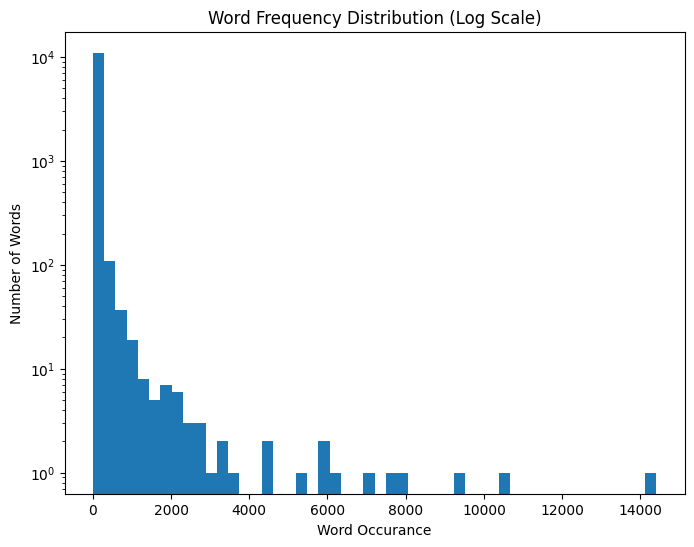

In [28]:
# word frequency distribution

word_counts = list(tokenizer.word_counts.values())

plt.figure(figsize=(8,6))
plt.hist(word_counts, bins=50, log=True)
plt.title("Word Frequency Distribution (Log Scale)")
plt.xlabel("Word Occurance")
plt.ylabel("Number of Words")
plt.show()

In [29]:
# Determining MAX_LEN
df['tweet_len'] = df['clean_text'].apply(lambda x: len(x.split()))

print(df['tweet_len'].describe())

count    27348.000000
mean        14.308651
std          7.049672
min          1.000000
25%          8.000000
50%         15.000000
75%         20.000000
max         49.000000
Name: tweet_len, dtype: float64


In [30]:
# Visualization of MAX_LEN
fig = px.histogram(df, x='tweet_len', nbins=50, title='Tweet Length Distribution')
fig.show()

For MAX_WORDS: 12000 is best due to low memory of google colab

While MAX_LEN: 50 is best as it will cover longest tweets in dataset

Now we got values for both now can be added in tokenization and pad_text

In [31]:
# Applying both values of parameters

MAX_WORDS = 12000
MAX_LEN = 50

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])

X = tokenizer.texts_to_sequences(df['clean_text'])
X_padded = pad_sequences(X, maxlen=MAX_LEN, padding='post')



In [32]:
# Train-test-split and balancing class weight as there is some imbalance in whole dataset


y = df['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42
)

# Adding Balance weight

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes,y=y_train)
class_weights = dict(zip(classes, class_weights))

In [33]:
# Building LSTM


hyperparams = [
    {'embedding_dim':32, 'lstm_units':32, 'dropout':0.2, 'batch_size':32, 'epochs':5},
    {'embedding_dim':64, 'lstm_units':64, 'dropout':0.3, 'batch_size':64, 'epochs':7},
    {'embedding_dim':128, 'lstm_units':128, 'dropout':0.3, 'batch_size':128, 'epochs':7}
]

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
]




In [34]:
# This will compare all models at same time

best_val_acc = 0
best_model=None
best_history=None

for i, params in enumerate(hyperparams):
    print(f"\n--- Training model {i+1}/{len(hyperparams)} ---")

    model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=params['embedding_dim'], input_length=MAX_LEN),
        Bidirectional(LSTM(params['lstm_units'], dropout=params['dropout'], recurrent_dropout=0.2)),
        Dense(3, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_data=(X_test, y_test),
        class_weight=class_weights,
        verbose=1,
        callbacks=callbacks
    )

    val_acc = max(history.history['val_accuracy'])
    print(f"Max Validation accuracy for this model: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model
        best_history = history
print(f"\nBest Validation Accuracy Achieved: {best_val_acc:.4f}")



--- Training model 1/3 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Epoch 1/5
684/684 ━━━━━━━━━━━━━━━━━━━━ 53s 67ms/step - accuracy: 0.5854 - loss: 0.8612 - val_accuracy: 0.8285 - val_loss: 0.4432 - learning_rate: 0.0010
Epoch 2/5
684/684 ━━━━━━━━━━━━━━━━━━━━ 37s 54ms/step - accuracy: 0.8652 - loss: 0.3738 - val_accuracy: 0.8782 - val_loss: 0.3452 - learning_rate: 0.0010
Epoch 3/5
684/684 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.9083 - loss: 0.2584 - val_accuracy: 0.8868 - val_loss: 0.3268 - learning_rate: 0.0010
Epoch 4/5
684/684 ━━━━━━━━━━━━━━━━━━━━ 37s 54ms/step - accuracy: 0.9336 - loss: 0.1968 - val_accuracy: 0.9015 - val_loss: 0.3026 - learning_rate: 0.0010
Epoch 5/5
684/684 ━━━━━━━━━━━━━━━━━━━━ 46s 61ms/step - accuracy: 0.9489 - loss: 0.1572 - val_accuracy: 0.9077 - val_loss: 0.2893 - learning_rate: 0.0010
Max Validation accuracy for this model: 0.9077

--- Training model 2/3 ---
Epoch 1/7
342/342 ━━━━━━━━━━━━━━━━━━━━ 37s 93ms/step - accuracy: 0.5797 - loss: 0.8658 - val_accuracy: 0.8282 - val_loss: 0.4542 - learning_rate: 0.0010
Epoch 2

In [35]:
# Evaluating best model
print(f"\nBest Validation Accuracy Achieved: {best_val_acc:.4f}")

# Evaluate on test data
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")



Best Validation Accuracy Achieved: 0.9141

Test Accuracy: 0.9141


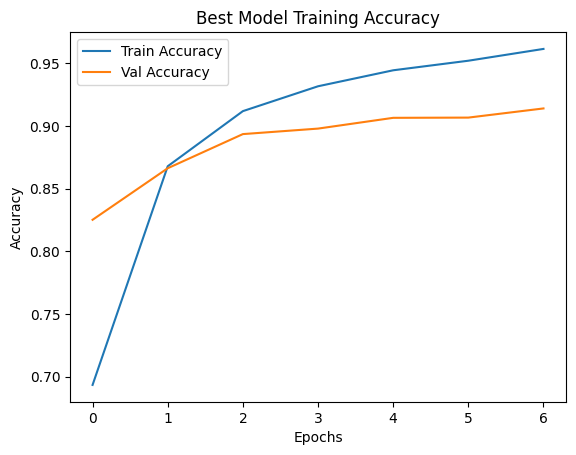

In [42]:
# Accuracy Plot
plt.plot(best_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Best Model Training Accuracy')
plt.show()

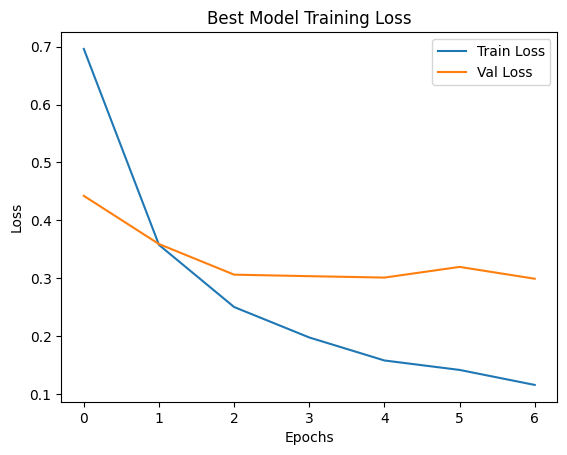

In [43]:
# Loss Plot
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Best Model Training Loss')
plt.show()

171/171 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step


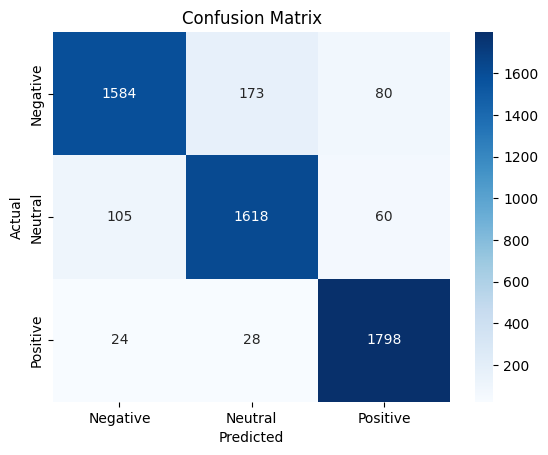

              precision    recall  f1-score   support

    Negative       0.92      0.86      0.89      1837
     Neutral       0.89      0.91      0.90      1783
    Positive       0.93      0.97      0.95      1850

    accuracy                           0.91      5470
   macro avg       0.91      0.91      0.91      5470
weighted avg       0.91      0.91      0.91      5470



In [37]:
# Confusion Matrix

y_pred = best_model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative','Neutral','Positive'],
            yticklabels=['Negative','Neutral','Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=['Negative','Neutral','Positive']))


In [38]:
# Save best model
best_model.save('/content/drive/My Drive/Dl Models/RNN/best_rnn_model_tuned.h5')
print("Best model saved successfully!")



Best model saved successfully!
